<a href="https://colab.research.google.com/github/wellecks/transformers4math-simons/blob/main/1_bigram/bigrams_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 1: Bigram language model

**Tutorial on Transformers for Mathematics**

*Simons Institute and SLMath Joint Workshop: AI for Mathematics and Theoretical Computer Science, April 8 2025*

Author: Sean Welleck

------

This notebook shows a very simple language model based on counting consecutive tokens.  


*Acknowledgements*: the content is based on Andrej Karpathy's makemore bigrams lecture ( [[youtube link](https://www.youtube.com/watch?v=PaCmpygFfXo)][[notebook]((https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part1_bigrams.ipynb))])


In [3]:
# Download data

!wget https://raw.githubusercontent.com/wellecks/transformers4math-simons/refs/heads/main/1_bigram/names.txt -O names.txt

--2025-04-08 16:06:33--  https://raw.githubusercontent.com/wellecks/transformers4math-simons/refs/heads/main/1_bigram/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  1.40MB/s    in 0.2s    

2025-04-08 16:06:34 (1.40 MB/s) - ‘names.txt’ saved [228145/228145]



### Bigram language model

A bigram language model predicts the next token given only the token immediately preceding it. For instance, when trying to predict `math`, the bigram language model would try to predict `t` only given `a`.



#### Learning to generate names

Let's walk through a simple example. We will learn to generate names using a bigram model. Here is our dataset:

In [4]:
data = open('names.txt').read().splitlines()

import random
random.sample(data, 10)

['jaaziel',
 'lan',
 'georgianna',
 'aceyn',
 'luana',
 'sorin',
 'lorcan',
 'raleigh',
 'dannia',
 'babacar']

Our dataset consists of names.

For simplicity, we will define a "token" as corresponding to a character. That is, the set of possible tokens (referred to as a "vocabulary") is the 26 English lowercase characters plus `[S]`.

In [5]:
# Tokenize the first example in the dataset
['[S]'] + list(data[0]) + ['[S]']

['[S]', 'e', 'm', 'm', 'a', '[S]']

We create a mapping between tokens (characters plus `[S]`) and numbers. This will make it easy to index into data structures such as matrices.

In [6]:
# Make a mapping from characters to indices and vice-versa
char_to_index = {char: i for i, char in enumerate('abcdefghijklmnopqrstuvwxyz')}
char_to_index['[S]'] = 26
index_to_char = {i: char for char, i in char_to_index.items()}

example = ['[S]'] + list(data[0]) + ['[S]']
[char_to_index[char] for char in example]

[26, 4, 12, 12, 0, 26]

### "Training" the bigram model

Now we will “train” the bigram model by setting its next-token probabilities based on how often each token $x_t$ appears after $x_{t-1}$ in the data:

\begin{align*}
p(x_t \mid x_{t-1})
= \frac{\text{count}(x_{t-1}, x_t)}{\sum_{x'} \text{count}(x_{t-1}, x')}.
\end{align*}


First, we count the bigrams:


In [7]:
# Step 1: count the bigrams
bigram_counts = {}
for x in data:
    sequence = ['[S]'] + list(x) + ['[S]']
    for x1, x2 in zip(sequence, sequence[1:]):
        bigram = (x1, x2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:10]

[(('n', '[S]'), 6763),
 (('a', '[S]'), 6640),
 (('a', 'n'), 5438),
 (('[S]', 'a'), 4410),
 (('e', '[S]'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('[S]', 'k'), 2963)]

Then we compute the probabilities:

In [8]:
# Step 2: compute the transition probabilities
import torch
P = torch.zeros((27, 27), dtype=torch.float32)

for (x1, x2), count in bigram_counts.items():
    i = char_to_index[x1]
    j = char_to_index[x2]
    P[i, j] = count

# Normalize the rows
P /= P.sum(dim=1, keepdim=True)

We can visualize the probabilities that the bigram model assigns to each (previous token, next token) pair:

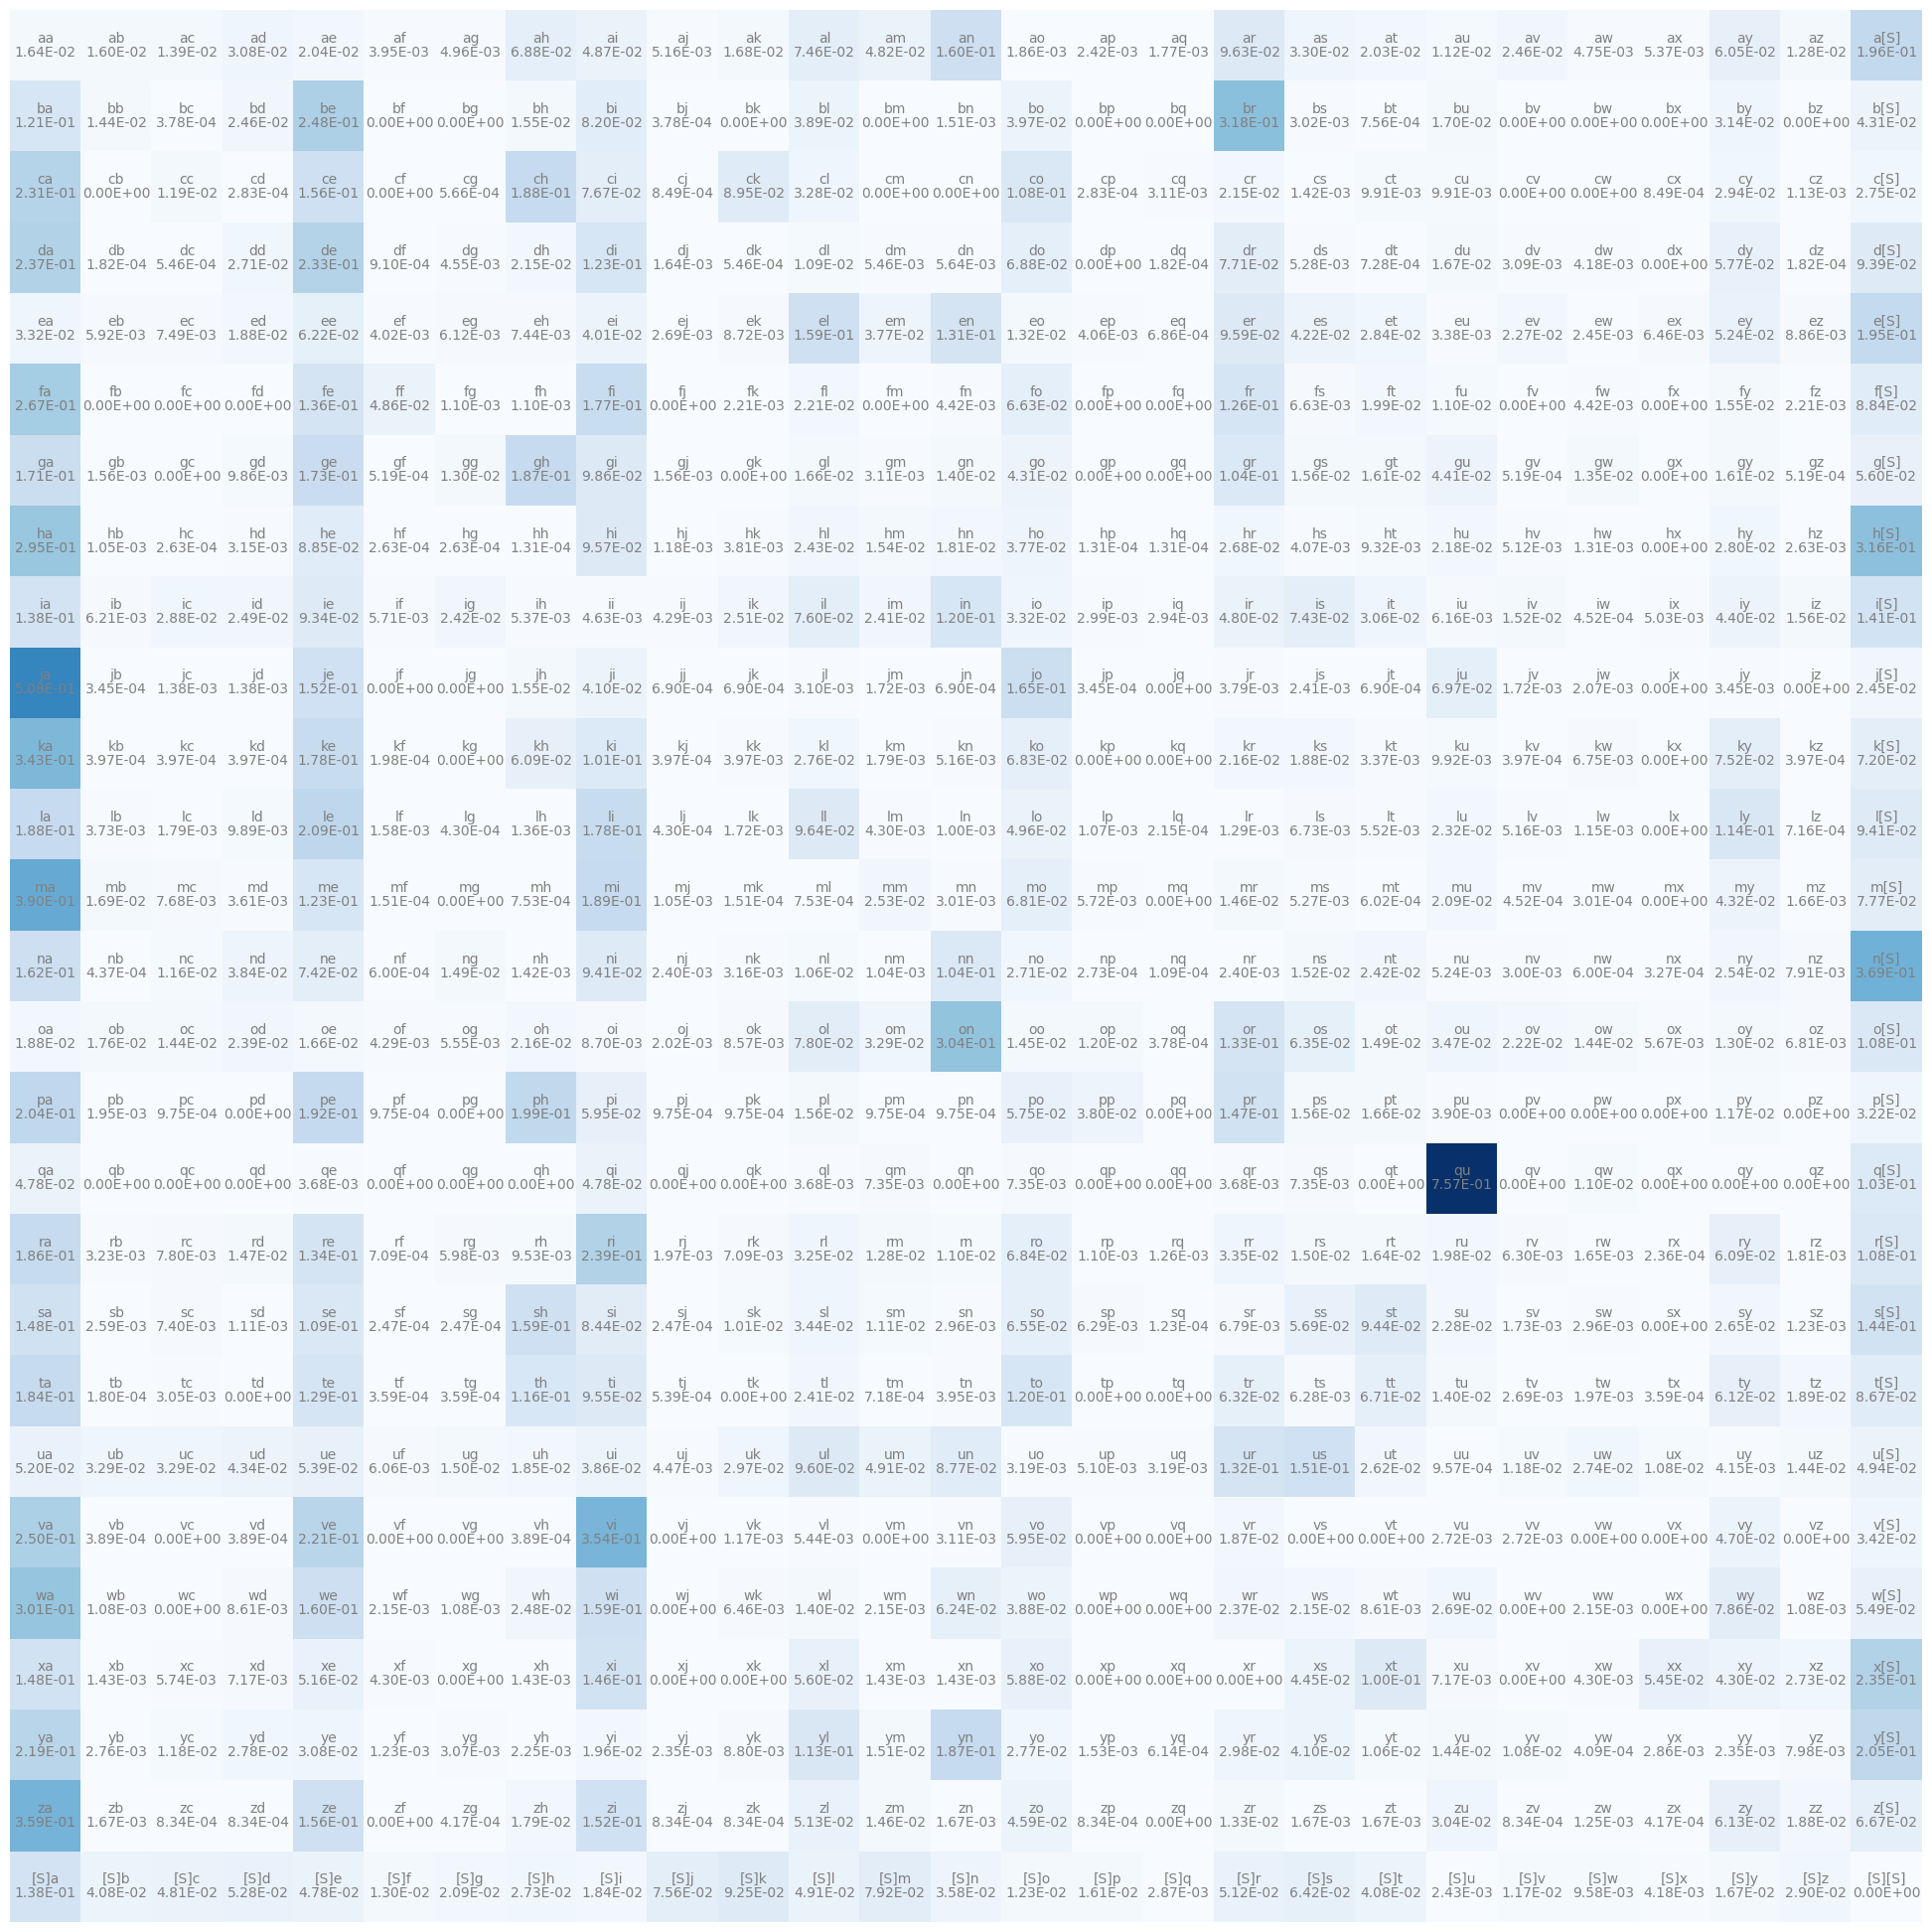

In [9]:
# Visualize the probabilities
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(25,25))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = index_to_char[i] + index_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, '%.2E' % P[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.show()

Questions
- Which token is most likely to start a sequence?
- Which token is most likely to end a sequence?
- Which token is most likely to follow token `v`?
- Which token pair has the highest probability according to the model?

### Generating new names with the bigram model

Now we can generate sequences using the bigram model. We will denote the model as $p_\theta$, where $\theta$ are the parameters of the model (i.e., the transition probabilities).

First, let's generate some first-tokens:

\begin{align*}
    x_1\sim p_\theta(\cdot|x_0)
\end{align*}

In [ ]:
index = torch.multinomial(
    P[char_to_index['[S]']],
    num_samples=10,
    replacement=True
)

[index_to_char[i.item()] for i in index]

['t', 'a', 'a', 'b', 'y', 'z', 'a', 'n', 'a', 'r']

To generate full sequences, we will start with the `[S]` token and iteratively sample the next token based on the current token's distribution. This process will continue until we sample the `[S]` token again, indicating the end of the sequence.

Here is the step-by-step process:

1. Start with the `[S]` token.
2. Sample the next token based on the current token's distribution.
3. Append the sampled token to the sequence.
4. Use the sampled token as the new current token.
5. Repeat steps 2-4 until the `[S]` token is sampled again.

Let's implement this in the next code cell.

In [ ]:
def generate_sequence():
    sequence = ['[S]']
    while True:
        current_char = sequence[-1]
        current_index = char_to_index[current_char]
        next_index = torch.multinomial(P[current_index], num_samples=1).item()
        next_char = index_to_char[next_index]
        if next_char == '[S]':
            break
        sequence.append(next_char)
    return ''.join(sequence[1:])

# Generate 10 sequences
generated_sequences = [generate_sequence() for _ in range(10)]
generated_sequences

['m',
 'xallshman',
 'be',
 'we',
 'shen',
 'jari',
 'eronin',
 'aux',
 'janatyala',
 'roriquwe']

Although the model is clearly not that good at generating new sequences (names), let's compare it to just uniformly sampling characters.

In [ ]:
import random

def generate_uniform_sequence():
    characters = list(char_to_index.keys())
    sequence = ['[S]']
    while True:
        next_char = random.choice(characters)
        if next_char == '[S]':
            break
        sequence.append(next_char)
    return ''.join(sequence[1:])

# Generate 10 sequences
uniform_sequences = [generate_uniform_sequence() for _ in range(10)]
uniform_sequences

['iwqpebp',
 'oryfoqkzmxbllqmxhkdktghejdhjnsyxhg',
 'wp',
 'swzyxoesilazidvqdapwwfltphijpyxcjvciwlzguxrdevmhlsanyivfnqwd',
 'hueoqknqtwxsbyugjntrtsvmcjszaflqtzyzvbkdkldptngzcsv',
 'xqzufjupeovvhlfcnwuvglxyqfrwxqsbpoxpsaoosqjndrdkdppskwnnwbczkwdquqjapcndrqwjsklcjlsc',
 'cbcfrqmsbuburmvrmzfkiuhasuuwwunicg',
 'hxyvodgpmhtofjgmngpncnrpelknipwcatywdhkryjqwwu',
 'wtnmrlqzvxlgwm',
 'y']

The bigram model clearly has a bit more structure than this uniform baseline.

#### Next steps

That's it for the bigram model! In the next notebook we'll train a Transformer that can generate much better names.

If you'd like to learn more background and train a simple neural bigram model, you can proceed to the optional advanced content below.

--------------------------


## Advanced content

#### A more formal presentation
Formally, a bigram language model assumes that the probability of a sequence of tokens $x_1,x_2,\ldots,x_T$ decomposes into:

\begin{align}
p(x_1, x_2, \ldots, x_T) = \prod_{t=1}^{T} p(x_t \mid x_{t-1}),
\end{align}

where $ p(x_t \mid x_{t-1}) $ is the conditional probability of token $ x_t $ given the previous token $ x_{t-1} $. We used a special token `[S]` to denote the start $x_0$ and end $x_T$ of a sequence.

#### Formal view of counting
It turns out that the counting procedure above corresponds to **maximizing the likelihood** of the entire corpus. In other words, we choose the setting of probabilities that maximizes
\begin{align*}
\prod_{\substack{\text{all pairs }(x_{t-1}, x_t) \\ \text{in the corpus}}}
p(x_t \mid x_{t-1}).
\end{align*}


### Evaluating the model using log-likelihood and perplexity
To evaluate the model, we can compute the **log-likelihood** of sequences in a dataset. The log-likelihood of a sequence is given by:

\begin{align*}
\log p(x_1, x_2, \ldots, x_T) = \sum_{t=1}^{T} \log p(x_t \mid x_{t-1})
\end{align*}

where $ p(x_t \mid x_{t-1}) $ is the conditional probability of token $ x_t $ given the previous token $ x_{t-1} $. We use log probabilities to avoid numerical underflow when multiplying many probabilities together.

In [ ]:
def log_likelihood(P, dataset):
    n = 0
    ll = 0
    for x in dataset:
        sequence = ['[S]'] + list(x) + ['[S]']
        for x1, x2 in zip(sequence, sequence[1:]):
            i = char_to_index[x1]
            j = char_to_index[x2]
            ll += torch.log(P[i, j])
            n += 1
    return ll, n

ll, n = log_likelihood(P, data)
print(f'Log likelihood: {ll.item():.4f}')
print(f'Average next-token log likelihood {ll.item() / n:.4f}')

Log likelihood: -559891.7500
Average next-token log likelihood -2.4541


It is common to report log-likelihood in terms of **perplexity**, which is defined on a per-token basis as:

\begin{align*}
\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log p(x_i \mid x_{i-1})\right)
\end{align*}

where $N$ is the total number of tokens in the dataset. Lower perplexity indicates a better model.

Check this great [blog post](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/) for more details about perplexity and related quantities in language models.

In [ ]:
def perplexity(model, dataset):
    ll, n = log_likelihood(model, dataset)
    return torch.exp(-ll / n).item()

perplexity(P, data)

11.635889053344727

**Exercise:** generalize the model above to an $n$-gram model (e.g., n = 2, 3, 4, ...)


## A simple neural bigram model

Next we will frame the above model in terms of **learning** a model with gradient descent. That is, we learn a weight matrix $W$ to parameterize a model $p(\cdot|x_{t-1})=W x_{t-1}$.

First we will make a training set of (previous token, next token) examples.

In [ ]:
# Make a training set
xs, ys = [], []
for x in data:
    sequence = ['[S]'] + list(x) + ['[S]']
    for x1, x2 in zip(sequence, sequence[1:]):
        xs.append(char_to_index[x1])
        ys.append(char_to_index[x2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
xs[:10], ys[:10]

(tensor([26,  4, 12, 12,  0, 26, 14, 11,  8, 21]),
 tensor([ 4, 12, 12,  0, 26, 14, 11,  8, 21,  8]))

Recall that we want to use a weight matrix $W$ to represent the probabilities. We can represent a token $x$ as a vector with a 1 in the token's vocabulary index and 0 everywhere else. This will let us get the next-token probabilities for an input $x_{t-1}$ by performing a matrix-vector multiplication.

A 0/1 vector of this form is referred to as a *one-hot* vector:

In [ ]:
torch.nn.functional.one_hot(xs, num_classes=27)[:3]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

Now we can directly train the model to maximize likelihood of the training data. Equivalently, we can minimize the negative log-likelihood.

In practice, given a training example $(x_{t-1},x_t)$ we can implement this minimization by forming a loss function and using backpropagation. The loss is applied to the model's probability of the next token $x_t$ given $x_{t-1}$ (see `nll_loss` below).

This procedure turns out to be equivalent to minimizing the cross entropy between the model's distribution and the underlying data distribution that the training set is assumed to be a sample from.

For more details and background, you can see these [Language modeling fundamentals slides](https://cmu-l3.github.io/anlp-spring2025/static_files/anlp-s2025-03-lm-seqmod.pdf) or its associated [lecture on Youtube](https://www.youtube.com/watch?v=9JuMXy-5Y0E&list=PLqC25OT8ZpD3WxQ0FwWMGPS_BcWdcKyZy&index=3).

In [ ]:
# W_ij is the probability of character j given character i
W = torch.randn(27, 27, requires_grad=True)
learning_rate = 20

def forward(x):
    xenc = torch.nn.functional.one_hot(x, num_classes=27).float()
    logits = xenc.matmul(W) # dim: (batch_size, 27)
    return logits

def nll_loss(logits, y):
    loss = -torch.nn.functional.log_softmax(logits, dim=1) # dim: (batch_size, 27)
    loss = loss[range(len(y)), y] # dim: (batch_size,)
    loss = loss.mean()
    return loss

for k in range(1000):
    logits = forward(xs)
    nll = nll_loss(logits, ys)
    loss = nll

    W.grad = None
    loss.backward()
    if k % 100 == 0:
        print(loss.item())

    W.data -= learning_rate * W.grad


3.9161274433135986
2.506355047225952
2.4773895740509033
2.4685351848602295
2.464479684829712
2.462162971496582
2.460648775100708
2.4595789909362793
2.458785057067871
2.4581756591796875


Now we can visualize the probabilities induced by the learned weight matrix $W$.

Log likelihood: -560746.5000
Average next-token log likelihood -2.4578


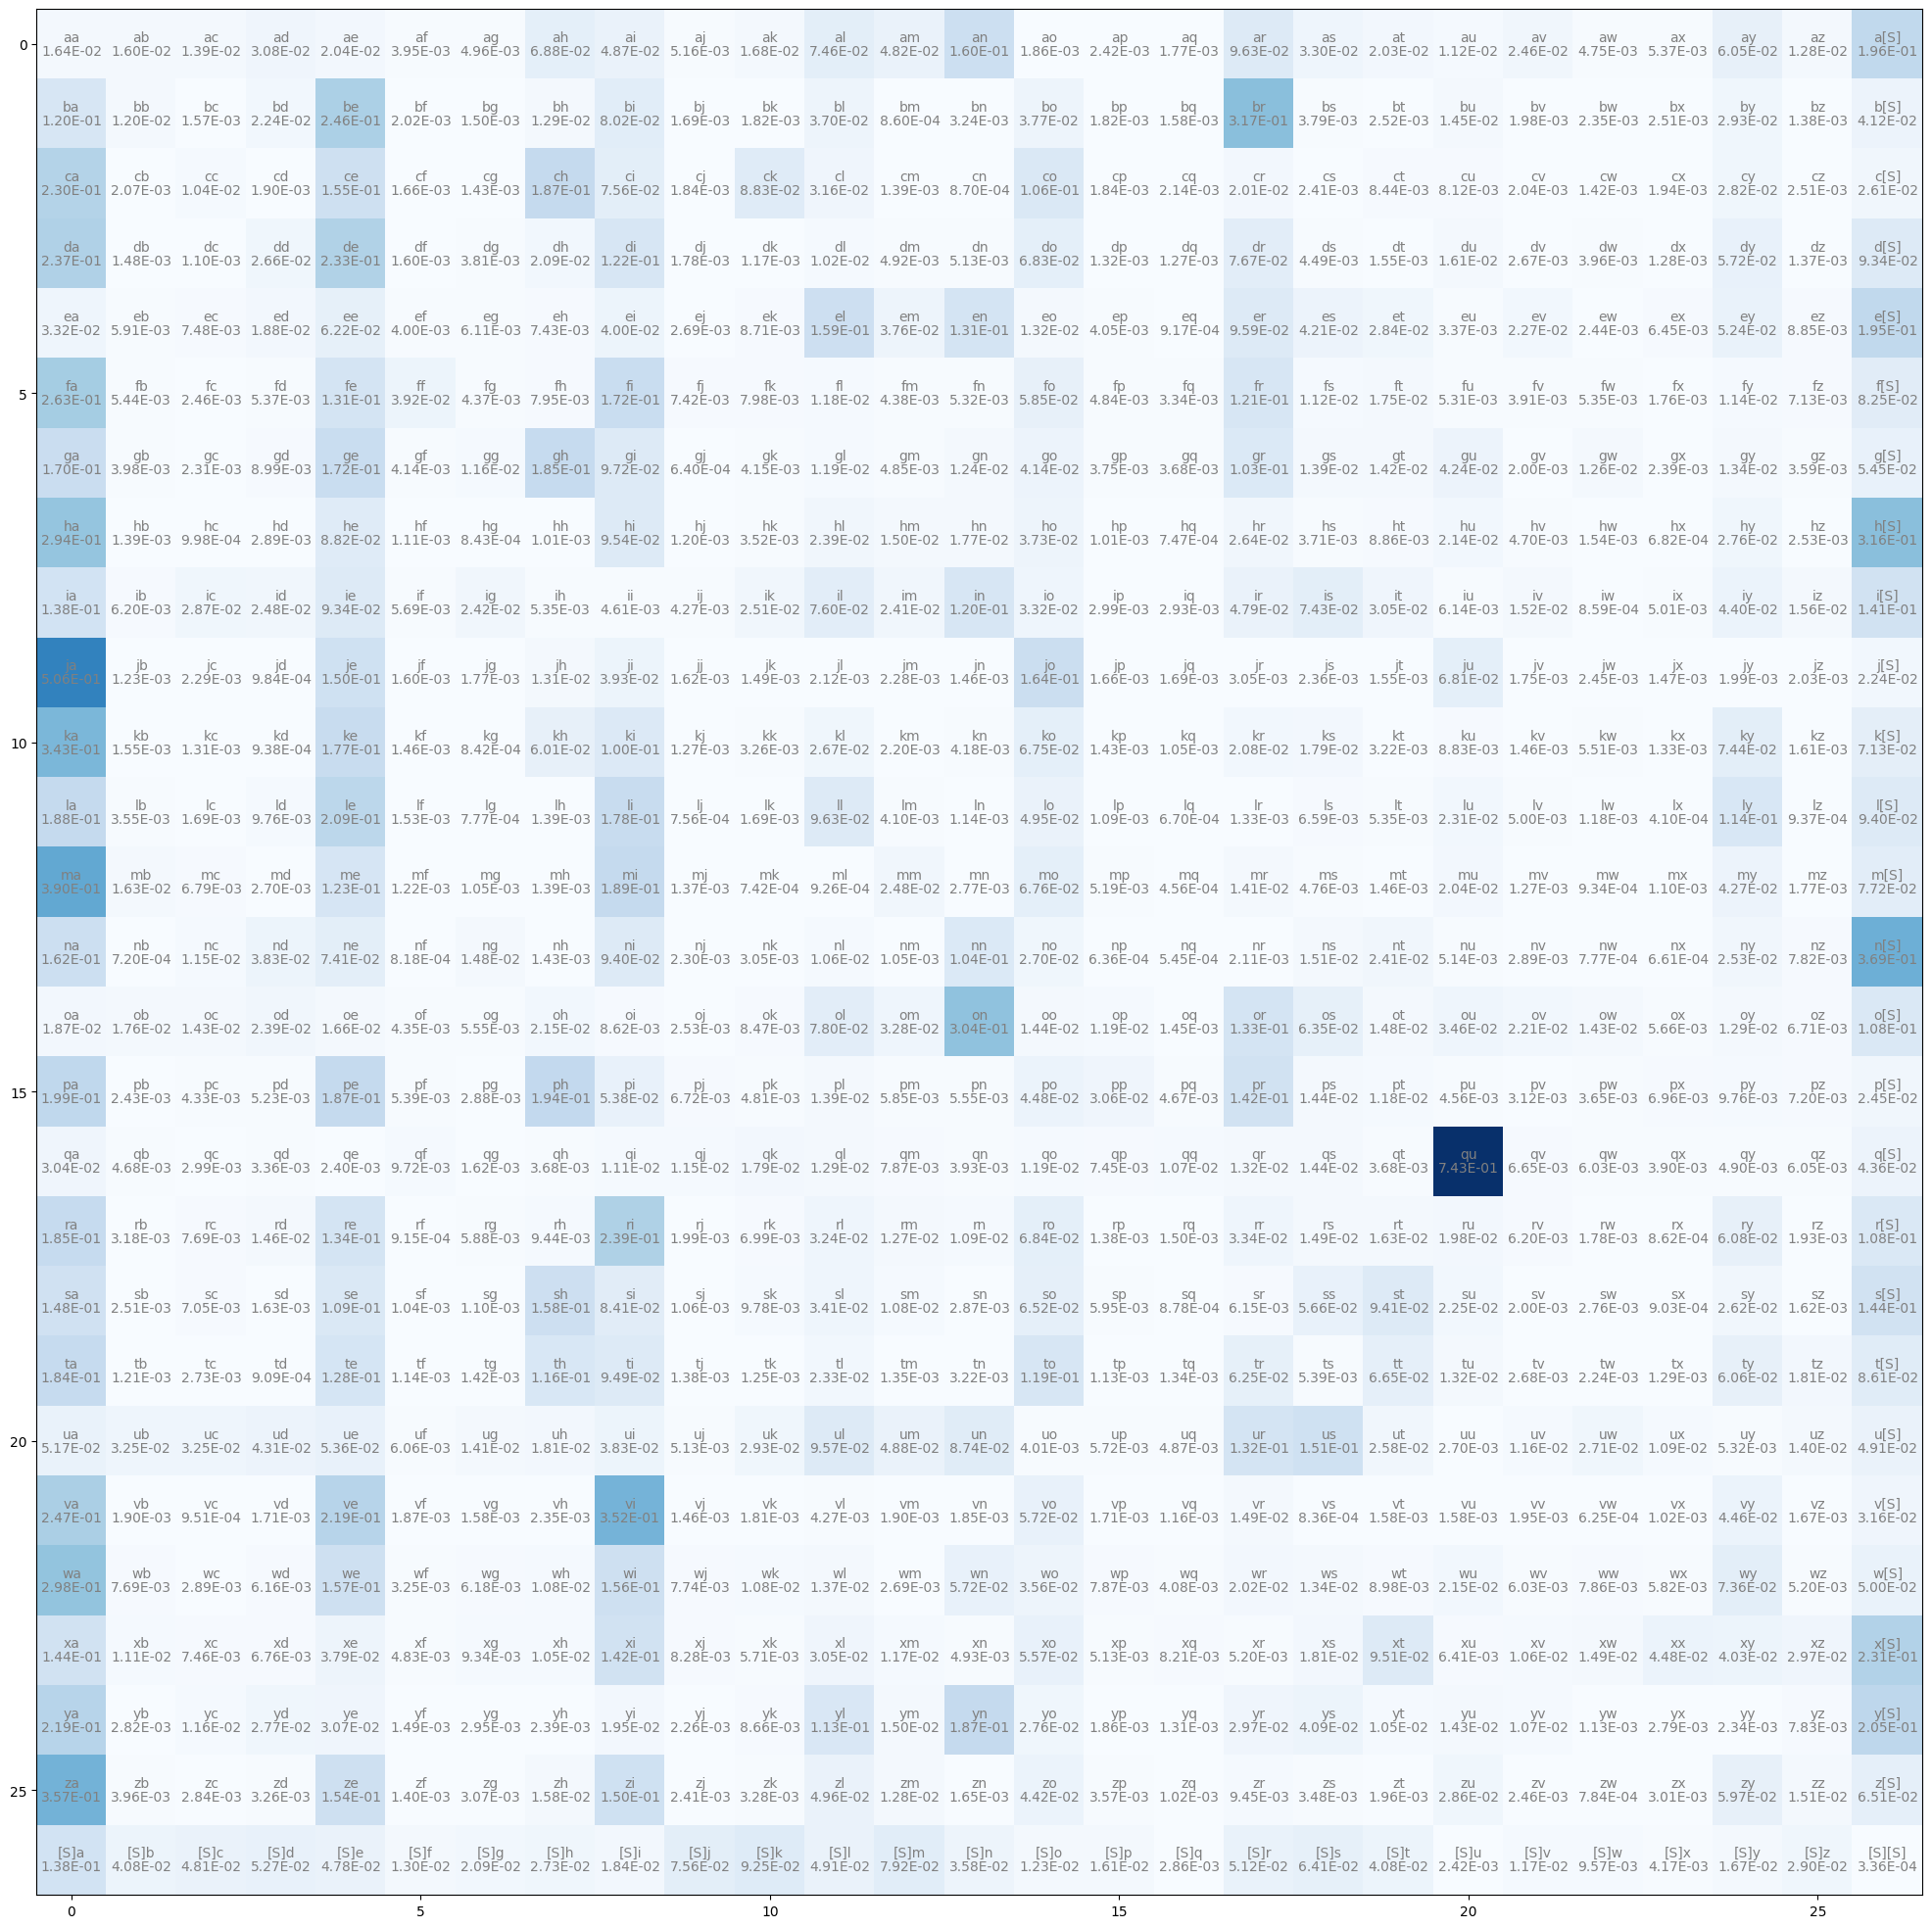

In [ ]:
# Visualize the model's probabilities
P_ = torch.nn.functional.softmax(W, dim=1).detach()

ll, n = log_likelihood(P_, data)
print(f'Log likelihood: {ll.item():.4f}')
print(f'Average next-token log likelihood {ll.item() / n:.4f}')

plt.figure(figsize=(25,25))
plt.imshow(P_.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = index_to_char[i] + index_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, '%.2E' % P_[i, j].item(), ha="center", va="top", color='gray')

Questions
- Which token is most likely to start a sequence?
- Which token is most likely to end a sequence?
- Which token is most likely to follow token `v`?
- Which token pair has the highest probability according to the model?

We can see that our simple learned model is quite similar to the one that was based on word counts.

In the next notebook, we will build a better neural network (a Transformer) that improves the ability to model and generate sequences.